In [65]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import time
from time import mktime
from matplotlib import pyplot as plt
import seaborn as sns
import patsy
from patsy import dmatrices
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import folium
from pandas import *
from folium.map import Icon, Marker, Popup
import pickle

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [115]:
NY_merged_samp = pd.read_pickle('../../datasets/NY_merged_samp.pkl')

In [116]:
NY_merged_samp.columns = NY_merged_samp.columns.str.replace(' ', '_')
NY_merged_samp.fillna(0, inplace=True)
NY_merged_samp['DATE'] = pd.to_datetime(NY_merged_samp['DATE'])
NY_merged_samp = NY_merged_samp.sort_values(by='DATE')
NY_merged_samp = NY_merged_samp[NY_merged_samp['DATE'] < '01/01/2017']


In [170]:
def borough(col):
    borough_cat = []
    for i in col:
        if i == 'BROOKLYN':
            borough_cat.append(1)
        elif i == 'MANHATTAN':
            borough_cat.append(2)
        elif i == 'QUEENS':
            borough_cat.append(3)
        elif i == 'BRONX':
            borough_cat.append(4)
        elif i == 'STATEN ISLAND':
            borough_cat.append(5)
        else:
            borough_cat.append(0)
    return borough_cat



def month_extract(col):
    MONTH = []
    for i in col:
        MONTH.append(i.month)
    return MONTH

## writing a function to extract the hour of the day from the datetime objects ('DATE' column) so that I can plot each 
## segment's volume of injury/death per each hour and see what time of day is most dangerous.

def hour_extract(col):
    HOUR = []
    for i in col:
        HOUR.append(i.hour)
    return HOUR

## making a function that will convert the Army time hour to a standard hour of the day (example: 20 --> 8pm)

def army_convert(col):
    std_hour = []
    for i in col:
        if i == 1:
            std_hour.append('1am')
        elif i == 2:
            std_hour.append('2am')
        elif i == 3:
            std_hour.append('3am')
        elif i == 4:
            std_hour.append('4am')
        elif i == 5:
            std_hour.append('5am')
        elif i == 6:
            std_hour.append('6am')
        elif i == 7:
            std_hour.append('7am')
        elif i == 8:
            std_hour.append('8am')
        elif i == 9:
            std_hour.append('9am')
        elif i == 10:
            std_hour.append('10am')
        elif i == 11:
            std_hour.append('11am')
        elif i == 12:
            std_hour.append('12pm')
        elif i == 13:
            std_hour.append('1pm')
        elif i == 14:
            std_hour.append('2pm')
        elif i == 15:
            std_hour.append('3pm')
        elif i == 16:
            std_hour.append('4pm')
        elif i == 17:
            std_hour.append('5pm')
        elif i == 18:
            std_hour.append('6pm')
        elif i == 19:
            std_hour.append('7pm')
        elif i == 20:
            std_hour.append('8pm')
        elif i == 21:
            std_hour.append('9pm')
        elif i == 22:
            std_hour.append('10pm')
        elif i == 23:
            std_hour.append('11pm')
        elif i == 0:
            std_hour.append('12am')
        else:
            pass
    
    return std_hour
        
## making a function that creates a list containing a '1' if there was a cyclist injured/killed and a '0' if there were
## no cyclists injured/killed

def binary(col):
    CYCLISTS_INJURED = []
    for i in col:
        if i > 0:
            CYCLISTS_INJURED.append(1)
        else:
            CYCLISTS_INJURED.append(0)
    return CYCLISTS_INJURED

def weather(col):
    rain = []
    for i in col:
        if i > 0:
            rain.append(1)
        else:
            rain.append(0)
    return rain

## building a function that separates the amount of precipitation in NYC into 6 varying buckets of intensity (0:5)

def precip(col):
    precip_cat = []
    for i in col:
        if (i > 0) & (i <= 1.00):
            precip_cat.append(1)
        elif (i > 1.00) & (i <= 2.00):
            precip_cat.append(2)
        elif (i > 2.00) & (i <= 3.00):
            precip_cat.append(3)
        elif (i > 3.00) & (i <= 4.00):
            precip_cat.append(4)
        elif (i > 4.00) & (i <= 5.00):
            precip_cat.append(5)
        else:
            precip_cat.append(0)
    return precip_cat


## building a function that separates the mean temperature/dewpoints of each day in NYC into 20+ buckets between 
## the range 0 and 100

def temp(col):
    temp_cat = []
    for i in col:
        if (i > -20) & (i <= -15):
            temp_cat.append(-3)
        elif (i > -15) & (i <= -10):
            temp_cat.append(-2)
        elif (i > -10) & (i <= -5):
            temp_cat.append(-1)
        elif (i > -5) & (i <= 0):
            temp_cat.append(0)
        elif (i > 0) & (i <= 5):
            temp_cat.append(1)
        elif (i > 5) & (i <= 10):
            temp_cat.append(2)
        elif (i > 10) & (i <= 15):
            temp_cat.append(3)
        elif (i > 15) & (i <= 20):
            temp_cat.append(4)
        elif (i > 20) & (i <= 25):
            temp_cat.append(5)   
        elif (i > 25) & (i <= 30):
            temp_cat.append(6)    
        elif (i > 30) & (i <= 35):
            temp_cat.append(7)
        elif (i > 35) & (i <= 40):
            temp_cat.append(8)
        elif (i > 40) & (i <= 45):
            temp_cat.append(9)
        elif (i > 45) & (i <= 50):
            temp_cat.append(10)
        elif (i > 45) & (i <= 50):
            temp_cat.append(11)
        elif (i > 50) & (i <= 55):
            temp_cat.append(12)
        elif (i > 55) & (i <= 60):
            temp_cat.append(13)
        elif (i > 60) & (i <= 65):
            temp_cat.append(14)
        elif (i > 65) & (i <= 70):
            temp_cat.append(15)
        elif (i > 70) & (i <= 75):
            temp_cat.append(16)
        elif (i > 75) & (i <= 80):
            temp_cat.append(17)
        elif (i > 80) & (i <= 85):
            temp_cat.append(18)
        elif (i > 85) & (i <= 90):
            temp_cat.append(19)
        elif (i > 90) & (i <= 95):
            temp_cat.append(20)
        else:
            temp_cat.append('NA')
    return temp_cat
            
            
            

In [118]:
NY_merged_samp['PrecipitationIn'].replace(to_replace='T', value=0.00, inplace=True)
NY_merged_samp['PrecipitationIn'] = NY_merged_samp['PrecipitationIn'].astype(float)

In [181]:
## setting up my features to include in my regression model

# NY_merged_samp['borough_cat'] = borough(NY_merged_samp['BOROUGH'])
# NY_merged_samp['precip_scale'] = precip(NY_merged_samp['PrecipitationIn'])
# NY_merged_samp['MONTH'] = month_extract(NY_merged_samp['DATE'])
# NY_merged_samp['CYCLISTS_INJURED'] = binary(NY_merged_samp['NUMBER_OF_CYCLIST_INJURED'])
# NY_merged_samp['temp_cat'] = temp(NY_merged_samp['Mean_TemperatureF'])
# NY_merged_samp['dew_cat'] = temp(NY_merged_samp['MeanDew_PointF'])
# NY_merged_samp['humid_cat'] = temp(NY_merged_samp['_Mean_Humidity'])


In [180]:
NY_merged_samp['_Mean_Humidity'].unique()

array([ 50.,  42.,  48.,  71.,  45.,  51.,  53.,  67.,  46.,  52.,  60.,
        56.,  57.,  61.,  76.,  68.,  70.,  79.,  87.,  62.,  75.,  63.,
        77.,  72.,  80.,  78.,  69.,  90.,  73.,  58.,  64.,  54.,  84.,
        65.,  66.,  81.,  82.,  55.,  88.,  89.,  92.,  74.,  59.,  47.,
        44.,  93.,  85.,  94.,  49.,  95.,  83.,  41.,  43.,  37.,  39.,
        40.,  33.,  31.,  36.,  32.,  86.,  35.,  34.,  38.,  30.,  91.,
        96.,  27.,  26.,  23.])

In [210]:
NY_merged_samp.columns

Index([u'DATE', u'TIME', u'BOROUGH', u'ZIP_CODE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION', u'ON_STREET_NAME', u'CROSS_STREET_NAME',
       u'OFF_STREET_NAME', u'NUMBER_OF_PERSONS_INJURED',
       u'NUMBER_OF_PERSONS_KILLED', u'NUMBER_OF_PEDESTRIANS_INJURED',
       u'NUMBER_OF_PEDESTRIANS_KILLED', u'NUMBER_OF_CYCLIST_INJURED',
       u'NUMBER_OF_CYCLIST_KILLED', u'NUMBER_OF_MOTORIST_INJURED',
       u'NUMBER_OF_MOTORIST_KILLED', u'CONTRIBUTING_FACTOR_VEHICLE_1',
       u'CONTRIBUTING_FACTOR_VEHICLE_2', u'CONTRIBUTING_FACTOR_VEHICLE_3',
       u'CONTRIBUTING_FACTOR_VEHICLE_4', u'CONTRIBUTING_FACTOR_VEHICLE_5',
       u'UNIQUE_KEY', u'VEHICLE_TYPE_CODE_1', u'VEHICLE_TYPE_CODE_2',
       u'VEHICLE_TYPE_CODE_3', u'VEHICLE_TYPE_CODE_4', u'VEHICLE_TYPE_CODE_5',
       u'Max_TemperatureF', u'Mean_TemperatureF', u'Min_TemperatureF',
       u'Max_Dew_PointF', u'MeanDew_PointF', u'Min_DewpointF', u'Max_Humidity',
       u'_Mean_Humidity', u'_Min_Humidity', u'_Max_Sea_Level_PressureIn',
   

In [ ]:
import itertools
def expandgrid(*itrs):
    product = list(itertools.product(*itrs))
    return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))}

months = NY_merged_samp.MONTH.unique()
pre_scale = NY_merged_samp['precip_scale'].unique()
borough = NY_merged_samp['borough_cat'].unique()
hour = NY_merged_samp.TIME.unique()
temp_cat = NY_merged_samp.temp_cat.unique()
dew_cat = NY_merged_samp.dew_cat.unique()
humid_cat = NY_merged_samp.humid_cat.unique()
cloud_cover = NY_merged_samp._CloudCover.unique()
wind_speed = NY_merged_samp._Mean_Wind_SpeedMPH.unique()

grid = expandgrid(months, pre_scale, borough, hour, temp_cat, dew_cat, humid_cat, cloud_cover, wind_speed)
grid = pd.DataFrame(grid)
grid.columns = ['months','precip','borough','hour', 'temp_cat', 'dew_cat', 'humid_cat', 'cloud_cover', 'wind_speed']

grid['bike_injuries'] = 0.

for m in months:
    NY_1 = NY_merged_samp[(NY_merged_samp['MONTH'] == m) & (NY_merged_samp['CYCLISTS_INJURED'] > 0)]
    for p in pre_scale:
        print m, p
        NY_2 = NY_1[NY_1['precip_scale'] == p]
        for b in borough:
            NY_3 = NY_2[NY_2['borough_cat'] == b]
            for h in hour:
                NY_4 = NY_3[NY_3['TIME'] == h]
                for t in temp_cat:
                    NY_5 = NY_4[NY_4['temp_cat'] == t]
                    for d in dew_cat:
                        NY_6 = NY_5[NY_5['dew_cat'] == d]
                        for hm in humid_cat:
                            NY_7 = NY_6[NY_6['humid_cat'] == hm]
                            for c in cloud_cover:
                                NY_8 = NY_7[NY_7['cloud_cover'] == c]
                                for w in wind_speed:
                                    ny_mask = (NY_8['wind_speed'] == w)
                        
                        
                                    grid_mask = (grid.months == m) & (grid.precip == p) & 
                                    (grid.borough == b) & (grid.hour == h) & (grid.temp_cat == t) &
                                    (grid.dew_cat == d) & (grid.humid_cat == hm) & (grid.cloud_cover == c) &
                                    (grid.wind_speed == w)
                                    
                
                                    injuries = NY_3.loc[ny_mask, 'CYCLISTS_INJURED'].sum()
                                    grid.loc[grid_mask, 'bike_injuries'] = injuries


In [75]:
grid.head()

,months,precip,borough,hour,bike_injuries
0,7,0,0,12,1.0
1,7,0,0,1,1.0
2,7,0,0,15,0.0
3,7,0,0,20,1.0
4,7,0,0,6,0.0


In [128]:
grid.groupby(['hour'])['bike_injuries'].sum()

hour
0     33.0
1     13.0
2      3.0
3      9.0
4      3.0
5      7.0
6     13.0
7     20.0
8     34.0
9     42.0
10    24.0
11    44.0
12    47.0
13    64.0
14    49.0
15    56.0
16    82.0
17    77.0
18    77.0
19    84.0
20    67.0
21    74.0
22    29.0
23    25.0
Name: bike_injuries, dtype: float64

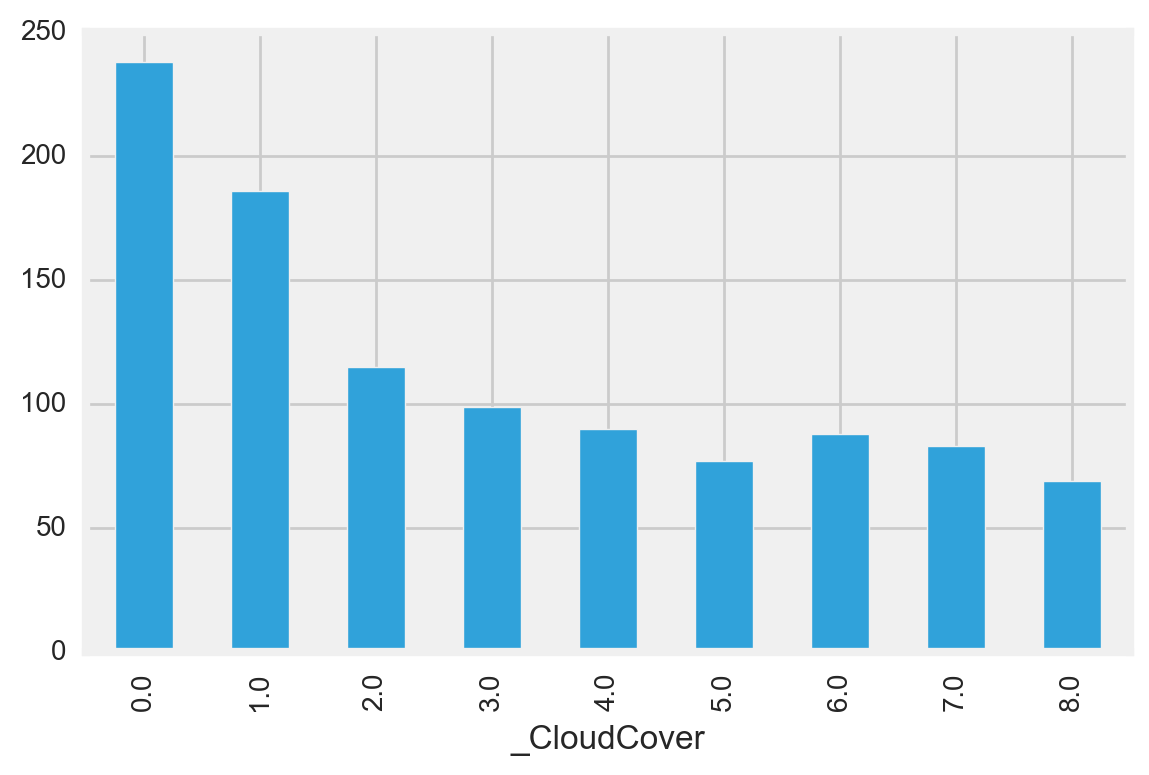

In [208]:
NY_merged_samp.groupby(['_CloudCover'])['NUMBER_OF_CYCLIST_INJURED'].sum().plot(kind='bar')

In [93]:
## first I'm scaling my data

from sklearn.preprocessing import StandardScaler

scaler      =  StandardScaler()
columns     =  ['months', 'precip', 'borough', 'hour', 'bike_injuries']
grid[columns] =  scaler.fit_transform(grid[columns])

In [143]:
## next step- throw the model into patsy and the regression built 

formula = "bike_injuries ~ C(months) + C(precip) + C(borough) + C(hour) -1"
y, X = patsy.dmatrices(formula, data=grid, return_type='dataframe')

In [141]:
from sklearn.preprocessing import StandardScaler

scaler      =  StandardScaler()
columns     =  ['months', 'bike_injuries']
grid[columns] =  scaler.fit_transform(grid[columns])

formula = "bike_injuries ~ C(months)"
y, X = patsy.dmatrices(formula, data=grid, return_type='dataframe')

In [144]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
model = lm.fit(X, y)
predictions  =  model.predict(X)
score = model.score(X, y)
    
print "R^2 score:", score

R^2 score: 0.179829450403


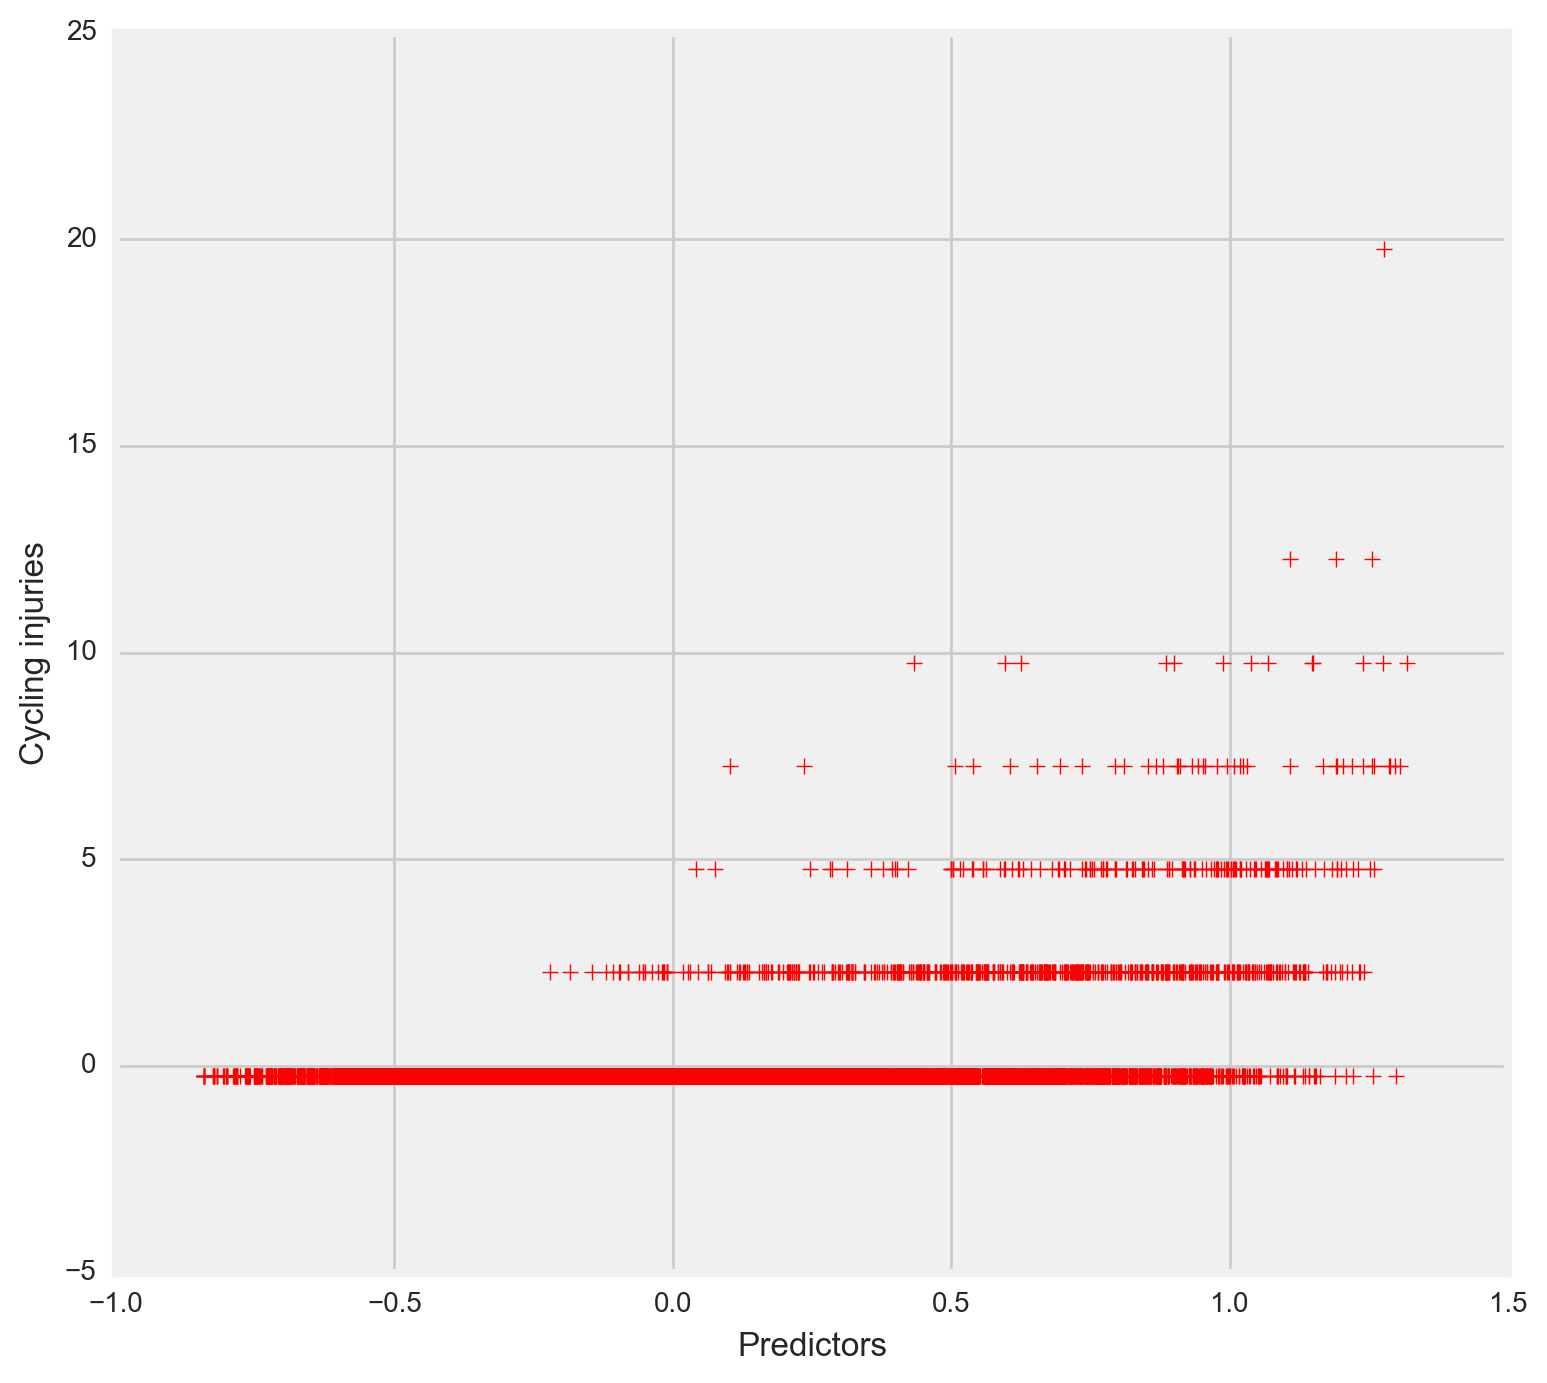

In [102]:
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predictors")
plt.ylabel("Cycling injuries")
plt.show()

In [103]:
print "MSE:", mean_squared_error(y, predictions)

print 

print "COEFS:", zip(X.columns, model.coef_)

print 

print "SCORE/R^2:", model.score(X, y)

MSE: 0.820168960647

COEFS: [('C(months)[-1.5932550136313832]', array([  1.43699746e+12,   1.43699746e+12,   1.43699746e+12,
         1.43699746e+12,   1.43699746e+12,   1.43699746e+12,
         1.43699746e+12,   1.43699746e+12,   1.43699746e+12,
         1.43699746e+12,   1.43699746e+12,   1.43699746e+12,
        -5.07162990e-01,  -8.90445367e-01,  -9.30914622e-01,
        -9.30889615e-01,  -9.32359720e-01,   2.62217606e-01,
         1.95692931e-01,   1.06025058e-01,  -7.90915529e-02,
        -1.73097444e-01,  -1.18534436e-01,  -1.75315668e-01,
        -1.40475300e-01,  -1.75315526e-01,  -1.52176112e-01,
        -1.16950036e-01,  -7.69726945e-02,   4.01544473e-03,
         5.02942487e-02,  -5.38332626e-02,   6.18639663e-02,
         7.94229551e-02,   1.77959258e-01,   9.07885359e-02,
         1.29475408e-01,   2.81405242e-01,   2.50679831e-01,
         2.52765114e-01,   2.93258974e-01,   1.95506746e-01,
         2.35234338e-01,  -2.49090697e-02,  -4.80485523e-02]))]

SCORE/R^2: 0.1798

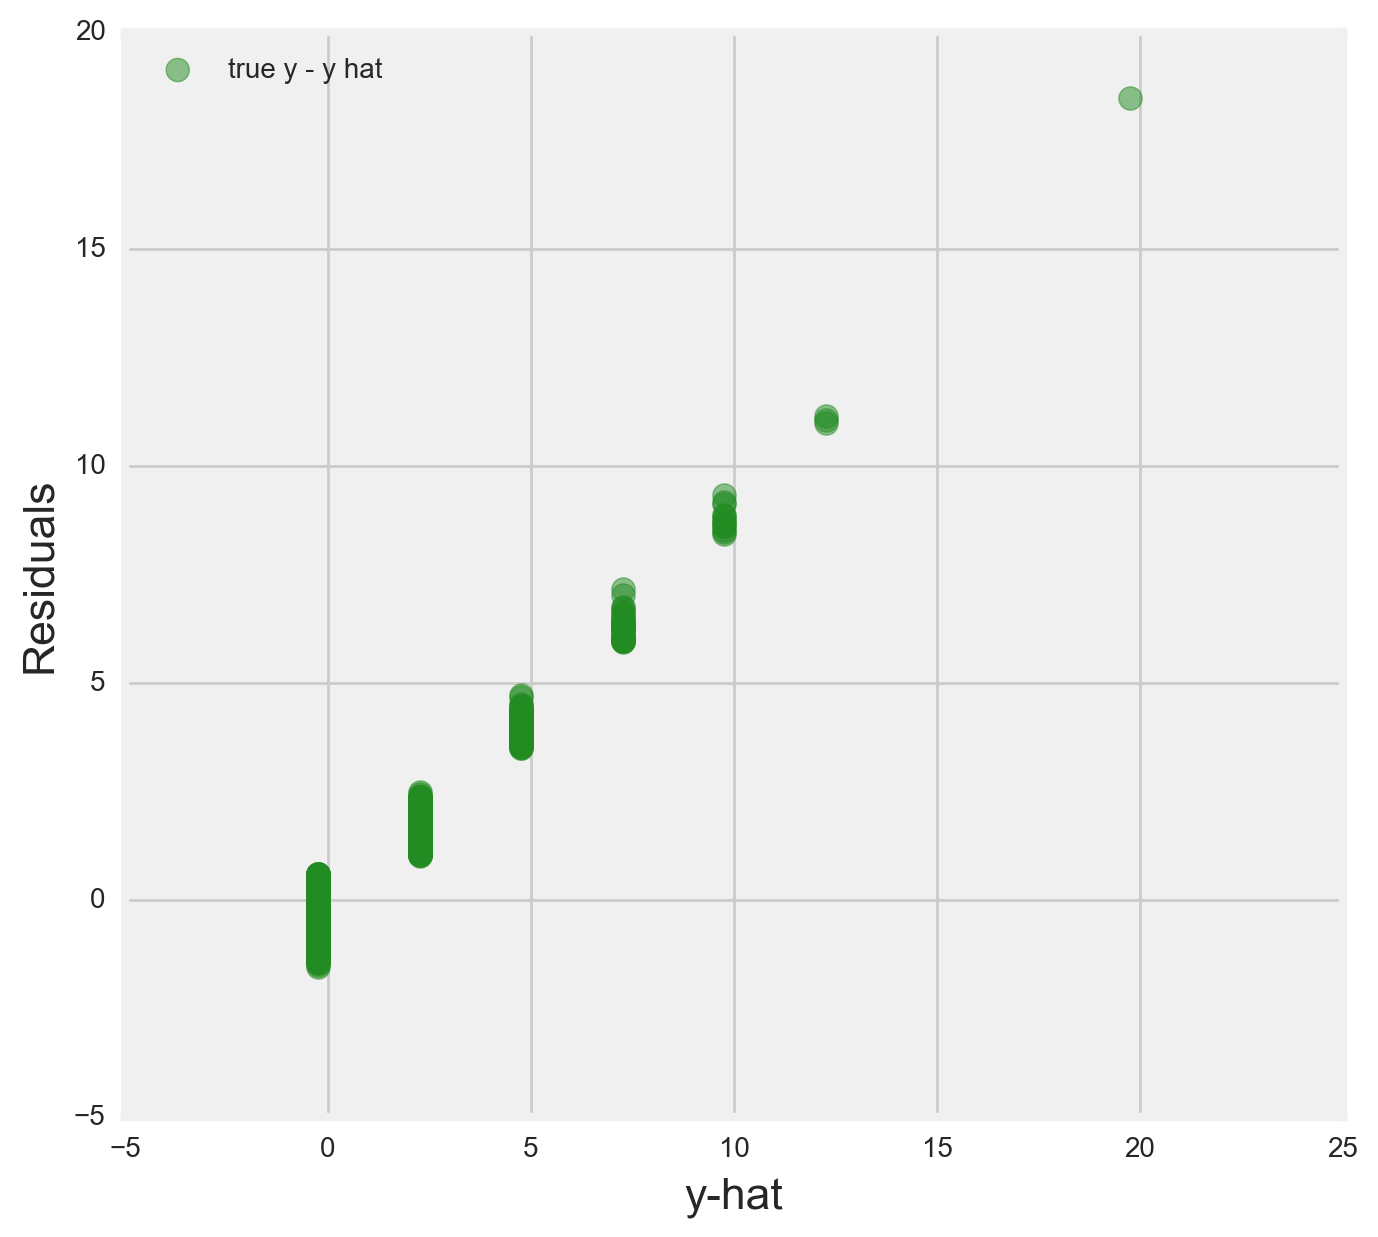

In [104]:
residuals = y - predictions

fig = plt.figure(figsize=(7,7))
ax = fig.gca()

ax.scatter(y, residuals, color='forestgreen', s=70, label='true y - y hat', alpha=.50)

max_x = np.max(y)+10

ax.set_xlabel('y-hat', fontsize=16)
ax.set_ylabel('Residuals', fontsize=16)

plt.legend(loc='upper left')

plt.show()

In [107]:
X.shape

(10368, 45)

In [105]:
strength = pd.DataFrame(model.coef_)
strength.index = X.columns
strength.plot(kind="bar")

ValueError: Length mismatch: Expected axis has 1 elements, new values have 45 elements